## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD/view?usp=drive_link
!gdown --id 1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD
From (redirected): https://drive.google.com/uc?id=1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD&confirm=t&uuid=8a13e751-817a-4768-97b5-52f23fcb127b
To: /content/daquar_vqa.zip
100% 431M/431M [00:04<00:00, 87.8MB/s]


In [ ]:
!unzip -q daquar_vqa.zip

## **1. Import libraries**

In [ ]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7

In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from random import randint
from torchvision import transforms
from torch.optim.lr_scheduler import LambdaLR
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**



In [ ]:
def read_qa_csv(qa_csv_path, img_dir):
    df = pd.read_csv(qa_csv_path)
    df = df.dropna()

    items = []
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image_id'] + '.png')
        question = row['question']
        answers = row['answer']

        if os.path.exists(img_path):
            item = {
                'img_path': img_path,
                'question': question,
                'answer': answers
            }
            items.append(item)

    return items

In [ ]:
data_dir = 'dataset'
img_dir = os.path.join(data_dir, 'images')
train_qa_csv_path = os.path.join(data_dir, 'data_train.csv')
test_qa_csv_path = os.path.join(data_dir, 'data_eval.csv')

train_data = read_qa_csv(train_qa_csv_path, img_dir)
test_data = read_qa_csv(test_qa_csv_path, img_dir)

## **3. Train/val/test split**

In [ ]:
val_size = 0.3
train_data, val_data = train_test_split(train_data,
                                        test_size=val_size,
                                        shuffle=True,
                                        random_state=seed)

## **4. Data Preprocessing**

In [ ]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

568

In [ ]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

def detokenize(tokens):
    reverse_vocab = vocab.get_itos()

    tokens = [reverse_vocab[token_id] for token_id in tokens]

    reconstructed_string = " ".join(tokens)

    return reconstructed_string

In [ ]:
example_question = "is this a picture of a table?"
max_seq_len = 30

tokens = tokenize(example_question, max_seq_len)
detokenized_question = detokenize(tokens)
print(f"Tokenized question: {tokens}")
print(f"Detokenized question: {detokenized_question}")

Tokenized question: [6, 92, 271, 53, 8, 271, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Detokenized question: is this a picture of a table <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
answer_space_path = os.path.join(data_dir,
                                 'answer_space.txt')
with open(answer_space_path, 'r') as f:
    answer_space = f.read().split('\n')
label2idx = {label: idx for idx, label in enumerate(answer_space)}
idx2label = {idx: label for idx, label in enumerate(answer_space)}
n_classes = len(answer_space)

print(f'Number of classes: {n_classes}')

Number of classes: 582


## **5. Create Pytorch dataset**

In [ ]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        max_seq_len=20,
        transform=None,
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[idx]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[idx]['answer']
        label = label.split(', ')[0]
        label = label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=transform
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=transform
)
test_dataset_visualize = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=transform_visualize
)

In [ ]:
train_batch_size = 128
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader_visualize = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Question: what is on the right side of the toy <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Ids: 483
Ground Truth: table


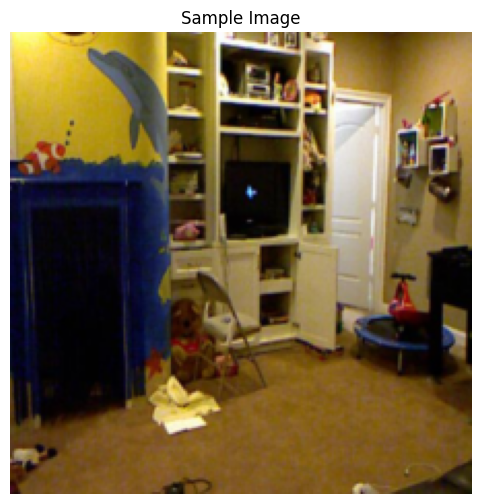

In [ ]:
sample_idx = 100
sample = test_dataset_visualize[sample_idx]
image, question, label = sample

plt.figure(figsize=(6, 6))
plt.imshow(image.permute(1, 2, 0).numpy())  # Convert to HWC format for plotting
plt.axis('off')
plt.title("Sample Image")

print(f"Question: {detokenize(question)}")
print(f"Ground Truth Ids: {label}")
print(f"Ground Truth: {idx2label[label.item()]}")

plt.show()

## **6. Create Model**

In [ ]:
import torch
import torch.nn as nn
import timm

class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet18',
        embeddding_dim=32,
        n_layers=2,
        hidden_size=64,
        drop_p=0.0,
        proj_dim=32,
        bidirect=False,
    ):
        super(VQAModel, self).__init__()
        # Image encoder
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        # Text embedding and LSTM
        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirect,
            dropout=drop_p
        )

        # Projection head
        self.MLP = nn.Sequential(
            nn.Linear(hidden_size + hidden_size, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, n_classes)
        )


    def forward(self, img, text):
        # Image features
        img_features = self.image_encoder(img)

        # Text features
        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)
        lstm_out = lstm_out[:, -1, :]

        # Concatenate image and text features
        x = torch.cat((img_features, lstm_out), dim=1)

        x = self.MLP(x)

        return x


In [ ]:
img_model_name = 'resnet18'
hidden_size = 64
n_layers = 2
embeddding_dim = 32
drop_p = 0.0
proj_dim = 32
bidirect = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p,
    proj_dim=proj_dim,
    bidirect=bidirect
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
images, questions, labels = next(iter(train_loader))
model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([128, 582])


## **7. Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, questions, labels in dataloader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        correct_train_preds = 0
        total_train_samples = 0

        for images, questions, labels in train_loader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, preds = torch.max(outputs.data, 1)
            correct_train_preds += (preds == labels).sum().item()
            total_train_samples += labels.size(0)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        train_acc = correct_train_preds / total_train_samples
        train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.0):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)

lr = 1e-3
epochs = 30
patience = 3

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.000100
Epoch 1, LR: 0.000280
Epoch 2, LR: 0.000460
Epoch 3, LR: 0.000640
Epoch 4, LR: 0.000820
Epoch 5, LR: 0.001000
Epoch 6, LR: 0.000960
Epoch 7, LR: 0.000920
Epoch 8, LR: 0.000880
Epoch 9, LR: 0.000840
Epoch 10, LR: 0.000800
Epoch 11, LR: 0.000760
Epoch 12, LR: 0.000720
Epoch 13, LR: 0.000680
Epoch 14, LR: 0.000640
Epoch 15, LR: 0.000600
Epoch 16, LR: 0.000560
Epoch 17, LR: 0.000520
Epoch 18, LR: 0.000480
Epoch 19, LR: 0.000440
Epoch 20, LR: 0.000400
Epoch 21, LR: 0.000360
Epoch 22, LR: 0.000320
Epoch 23, LR: 0.000280
Epoch 24, LR: 0.000240
Epoch 25, LR: 0.000200
Epoch 26, LR: 0.000160
Epoch 27, LR: 0.000120
Epoch 28, LR: 0.000080
Epoch 29, LR: 0.000040


In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    patience
)

Epoch 1/30 - Train Loss: 6.2888 - Train Acc: 0.0159 - Val Loss: 6.2367 - Val Acc: 0.0150
Epoch 2/30 - Train Loss: 5.8756 - Train Acc: 0.0311 - Val Loss: 5.5929 - Val Acc: 0.0331
Epoch 3/30 - Train Loss: 4.9567 - Train Acc: 0.0689 - Val Loss: 5.1004 - Val Acc: 0.0461
Epoch 4/30 - Train Loss: 4.5525 - Train Acc: 0.0955 - Val Loss: 4.8243 - Val Acc: 0.0869
Epoch 5/30 - Train Loss: 4.2053 - Train Acc: 0.1422 - Val Loss: 4.8563 - Val Acc: 0.0775
Epoch 6/30 - Train Loss: 4.0051 - Train Acc: 0.1540 - Val Loss: 4.7839 - Val Acc: 0.0952
Epoch 7/30 - Train Loss: 3.7653 - Train Acc: 0.1743 - Val Loss: 4.7215 - Val Acc: 0.0919
Epoch 8/30 - Train Loss: 3.5448 - Train Acc: 0.2008 - Val Loss: 4.7382 - Val Acc: 0.0842
Epoch 9/30 - Train Loss: 3.3317 - Train Acc: 0.2163 - Val Loss: 4.7788 - Val Acc: 0.0912
Epoch 10/30 - Train Loss: 3.1608 - Train Acc: 0.2328 - Val Loss: 4.9070 - Val Acc: 0.0925
Early stopping triggered after 10 epochs.


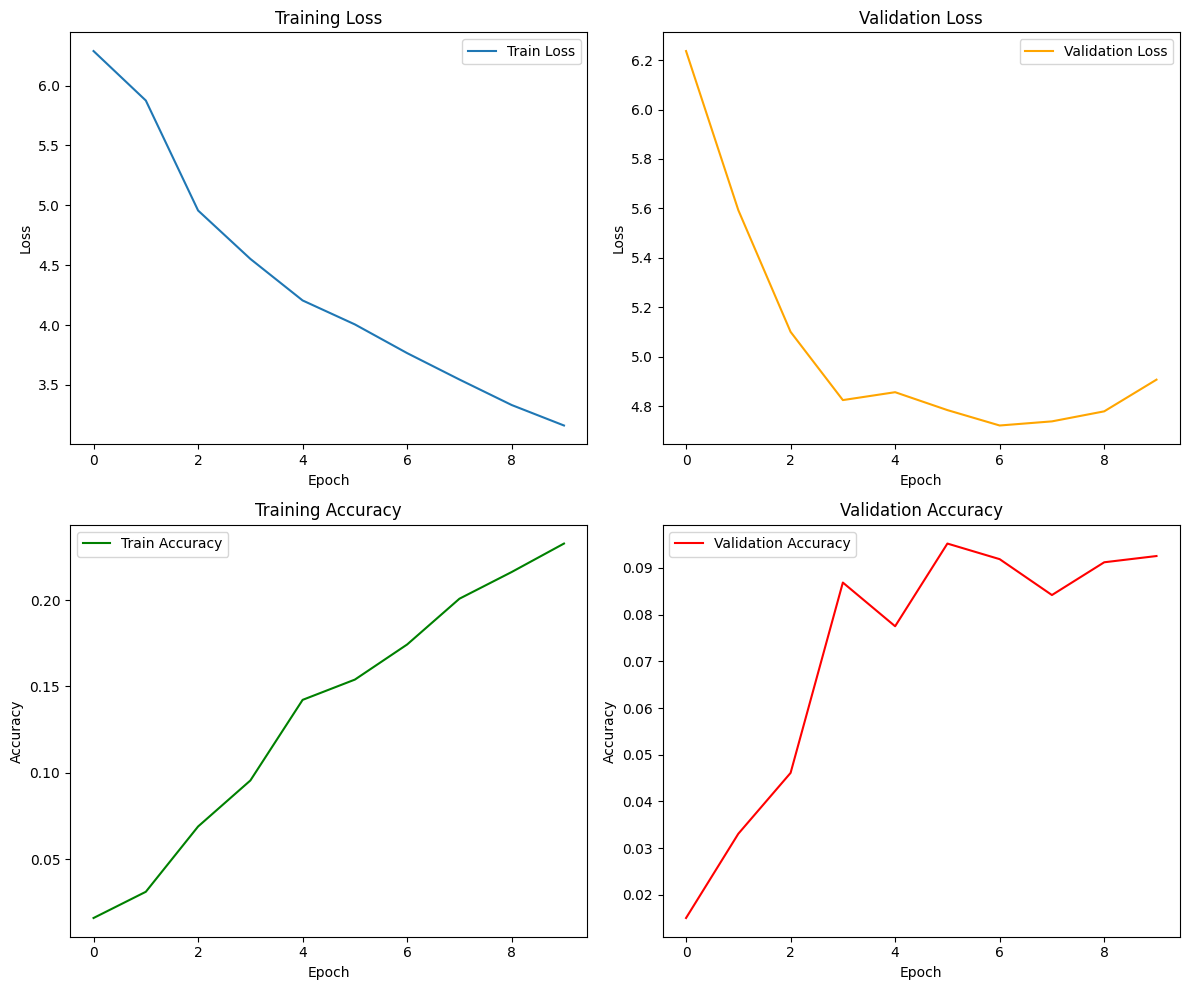

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot Training Loss
ax[0, 0].plot(train_losses, label='Train Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

# Plot Validation Loss
ax[0, 1].plot(val_losses, label='Validation Loss', color='orange')
ax[0, 1].set_title('Validation Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

# Plot Training Accuracy
ax[1, 0].plot(train_accuracies, label='Train Accuracy', color='green')
ax[1, 0].set_title('Training Accuracy')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].legend()

# Plot Validation Accuracy
ax[1, 1].plot(val_accuracies, label='Validation Accuracy', color='red')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

## **8. Evaluation**

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on test dataset')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Evaluation on test dataset
Test loss:  4.83350293636322
Test accuracy:  0.10465116279069768


## **9. Inference**

In [ ]:
def demo(amount):
  model.eval()

  for i in range(amount):
    sample_idx = randint(0, n_classes)
    image, question, label = test_dataset[sample_idx]
    image_viz, _, _ = test_dataset_visualize[sample_idx]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.unsqueeze(0).to(device)
    question = question.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image, question)
        _, preds = torch.max(outputs.data, 1)

    original_question = detokenize(question.squeeze().cpu().numpy())
    true_labels = [idx2label[label.item()]]
    predicted_labels = [idx2label[preds.item()]]

    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(image_viz.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1))
    plt.axis('off')
    plt.title("Image from Test Dataset")

    print(f"Question: {original_question}")
    print(f"Ground Truth Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")

    plt.show()

Question: how many <unk> are visible <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['1']
Predicted Labels: ['1']


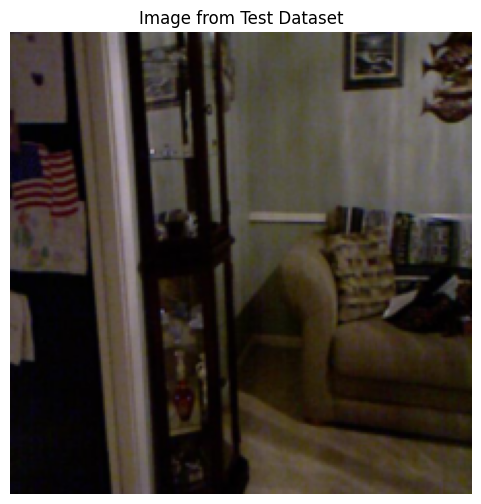

Question: what is in front of table <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['door']
Predicted Labels: ['ladder']


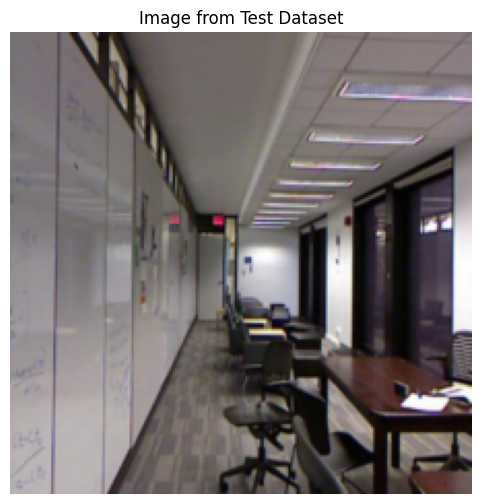

Question: what is the colour of <unk> chair <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['black']
Predicted Labels: ['bag']


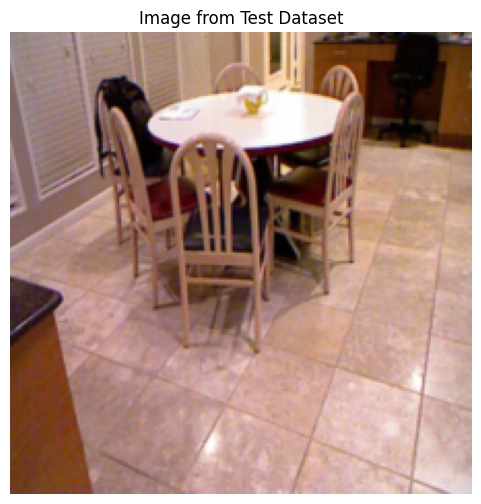

In [ ]:
demo(3)

## **10. Save and Download the model**

In [ ]:
save_path = '/content/student.pt'
torch.save(model.state_dict(), save_path)